# QuTiPv5 Paper Example: Stochastic Solver - Homodyne Detection

Authors: Maximilian Meyer-Mölleringhof (m.meyermoelleringhof@gmail.com), Neill Lambert (nwlambert@gmail.com)

## Introduction

When modelling an open quantum system, stochastic noise can be used to simulate a large range of phenomena.
In the `smesolve()` solver, noise is introduced by continuous measurement.
This allows us to generate the trajectory evolution of a quantum system conditioned on a noisy measurement record.
Historically speaking, such models were used by the quantum optics community to model homodyne and heterodyne detection of light emitted from a cavity.
However, this solver is of course quite general and can thus also be applied to other problems.

In this example we look at an optical cavity whose output is subject to homodyne detection.
Such a cavity obeys the general stochastic master equation

$d \rho(t) = -i [H, \rho(t)] dt + \mathcal{D}[a] \rho (t) dt + \mathcal{H}[a] \rho\, dW(t)$

with the Hamiltonian

$H = \Delta a^\dagger a$

and the Lindblad dissipator

$\mathcal{D}[a] = a \rho a^\dagger - \dfrac{1}{2} a^\dagger a \rho - \dfrac{1}{2} \rho a^\dagger a$.

The stochastic part

$\mathcal{H}[a]\rho = a \rho + \rho a^\dagger - tr[a \rho + \rho a^\dagger]$

captures the conditioning of the trajectory through continuous monitoring of the operator $a$.
The term $dW(t)$ is the increment of a Wiener process that obeys $\mathbb{E}[dW] = 0$ and $\mathbb{E}[dW^2] = dt$.

Note that a similiar example is available in the [QuTiP user guide](https://qutip.readthedocs.io/en/qutip-5.0.x/guide/dynamics/dynamics-stochastic.html#stochastic-master-equation).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import about, coherent, destroy, mesolve, smesolve

%matplotlib inline

## Problem Parameters

In [2]:
N = 20  # dimensions of Hilbert space
delta = 10 * np.pi  # cavity detuning
kappa = 1  # decay rate
A = 4  # initial coherent state intensity

In [3]:
a = destroy(N)
x = a + a.dag()  # operator for expectation value
H = delta * a.dag() * a  # Hamiltonian
mon_op = np.sqrt(kappa) * a  # continiously monitored operators

## Solving for the Time Evolution

We calculate the predicted trajectory conditioned on the continuous monitoring of the operator $a$.
This is compared to the regular `mesolve()` solver for the same model but without resolving conditioned trajectories.

In [4]:
rho_0 = coherent(N, np.sqrt(A))  # initial state
times = np.arange(0, 1, 0.0025)
num_traj = 500  # number of computed trajectories
opt = {"dt": 0.00125, "store_measurement": True, "map": "parallel"}

In [5]:
me_solution = mesolve(H, rho_0, times, c_ops=[mon_op], e_ops=[x])

In [6]:
stoc_solution = smesolve(
    H, rho_0, times, sc_ops=[mon_op], e_ops=[x], ntraj=num_traj, options=opt
)

10.0%. Run time:   0.88s. Est. time left: 00:00:00:07


20.0%. Run time:   1.70s. Est. time left: 00:00:00:06


30.0%. Run time:   2.49s. Est. time left: 00:00:00:05


40.0%. Run time:   3.34s. Est. time left: 00:00:00:05


50.0%. Run time:   4.13s. Est. time left: 00:00:00:04


60.0%. Run time:   4.98s. Est. time left: 00:00:00:03


70.0%. Run time:   5.79s. Est. time left: 00:00:00:02


80.0%. Run time:   6.59s. Est. time left: 00:00:00:01


90.0%. Run time:   7.42s. Est. time left: 00:00:00:00


100.0%. Run time:   8.22s. Est. time left: 00:00:00:00


Total run time:   8.23s


## Comparison of Results

We plot the averaged homodyne current $J_x = \langle x \rangle + dW / dt$ and the average system behaviour $\langle x \rangle$ for 500 trajectories.
This is compared with the prediction of the regular `mesolve()` solver that does not include the conditioned trajectories.
Since the conditioned expectation values do not depend on the trajectories, we expect that this reproduces the result of the standard `mesolve()`.

In [7]:
stoc_meas_mean = np.array(stoc_solution.measurement).mean(axis=0)[0, :].real

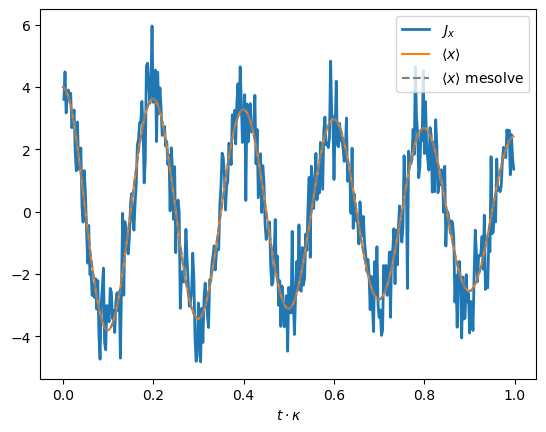

In [8]:
plt.figure()
plt.plot(times[1:], stoc_meas_mean, lw=2, label=r"$J_x$")
plt.plot(times, stoc_solution.expect[0], label=r"$\langle x \rangle$")
plt.plot(
    times,
    me_solution.expect[0],
    "--",
    color="gray",
    label=r"$\langle x \rangle$ mesolve",
)

plt.legend()
plt.xlabel(r"$t \cdot \kappa$")
plt.show()

## References

[1] [QuTiP 5: The Quantum Toolbox in Python](https://arxiv.org/abs/2412.04705)

## About

In [9]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

In [10]:
assert np.allclose(
    stoc_solution.expect[0], me_solution.expect[0], atol=1e-1
), "smesolve and mesolve do not preoduce the same trajectory."